In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import warnings
import pingouin as pg

In [14]:
from random import choices
from scipy import stats
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex

In [15]:
from jupyter_utils import add_grey

In [16]:
import statsmodels.api as sm

In [17]:
# warnings.simplefilter("ignore")
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [18]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/'

In [19]:
PATH_FIG = '/Users/galina.ryazanskaya/Downloads/thesis?/figures/'

In [20]:
long_df_ru = pd.read_csv(PATH + 'long_ru.csv', index_col=0)

In [21]:
long_df_de = pd.read_csv(PATH + 'long_de.csv', index_col=0)

In [22]:
long_df = pd.concat([long_df_ru, long_df_de])
long_df.tail()

,lang,task,scale,performance_metric,metric_group,metric_name,median,mean,CI_low,CI_high,...,corr_mean_sent_len_CI_low,corr_mean_sent_len_CI_high,corr_n_sents_median,corr_n_sents_mean,corr_n_sents_CI_low,corr_n_sents_CI_high,corr_n_words_median,corr_n_words_mean,corr_n_words_CI_low,corr_n_words_CI_high
1627,de,sadness,sample_raw,sample_raw,graph,PE,0.072718,0.092412,0.028025,0.144375,...,0.161599,0.301020,0.482556,0.483487,0.430986,0.540829,0.413537,0.414719,0.368688,0.460928
1628,de,sadness,sample_raw,sample_raw,graph,degree_average,0.053097,0.080566,0.014317,0.124021,...,0.231586,0.390299,0.434464,0.432834,0.386642,0.482012,0.411861,0.410253,0.367080,0.455254
1629,de,sadness,sample_raw,sample_raw,graph,degree_std,0.100820,0.117550,0.044424,0.174172,...,0.309745,0.450923,0.463002,0.460349,0.414120,0.509225,0.466058,0.464205,0.423372,0.503094
1630,de,sadness,sample_raw,sample_raw,graph,number_of_edges,0.209177,0.212705,0.144147,0.277617,...,0.402361,0.510313,0.530675,0.529984,0.499753,0.560742,0.560653,0.561677,0.528005,0.592891
1631,de,sadness,sample_raw,sample_raw,graph,number_of_nodes,0.207853,0.209475,0.143152,0.270386,...,0.339156,0.452717,0.412672,0.404037,0.358598,0.452844,0.453008,0.452813,0.410813,0.496868


In [23]:
raw_long_df = long_df[long_df['performance_metric'] == 'sample_raw']

In [24]:
long_df = long_df[long_df['performance_metric'] != 'sample_raw']

## Assign colors to metrics

fix metric colors - dict (color by group)  \
fix metric order

In [25]:
metric_groups = {group: long_df[long_df['metric_group'] == group]['metric_name'].unique().tolist() for group in long_df['metric_group'].unique()}

In [26]:
LM_groups_metrics = {}
LM_groups_models = {}
for metric_name in metric_groups['LM']:
    model, metric = metric_name.rsplit('_', 1)
    LM_groups_metrics.setdefault(metric, []).append(metric_name)
    LM_groups_models.setdefault(model, []).append(metric_name)

In [27]:
group_to_color = {'graph': "#fbacb9", # '#ad017e', 
                  'lexical': '#8e2f6d', 'syntactic': '#e2191c', 'LM': "#1d5b5d"}
group_to_palette = {'graph': 'RdPu', 'lexical': 'Purples', 'syntactic': 'YlOrRd'}

In [28]:
model_to_color = {'bert': '#3b6a2a', 'glove_avg': '#1d5b5d', 'glove_tf': '#274754', 'w2v_avg': '#0c2c41', 'w2v_tf': '#1d3658'}

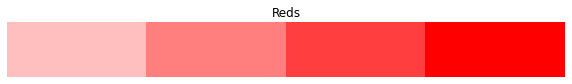

In [29]:
def sample_categorical_palette(color_name, size, cmap=None, low=0.25):
    """
    Samples evenly from a continuous colormap ranging from light-shade to a full color,
    to create a categorical palette.
    
    Parameters:
    - color_name (str): Name of the target color (e.g., "blue", "red", "#ff5733").
    - size (int): Number of discrete colors in the resulting categorical palette.
    
    Returns:
    - list: A list of RGB tuples representing the categorical palette.
    """
    # Get the colormap
    if not cmap:
        cmap = LinearSegmentedColormap.from_list("custom_colormap", ["white", color_name])
    
    # Sample evenly spaced values between low and 1
    colors = [cmap(i) for i in np.linspace(low, 1, size)]
    
    return colors

# Visualize the sampled palette
def visualise_palette(palette, title):
    plt.figure(figsize=(10, 1))
    plt.imshow([palette], aspect="auto")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example usage:
categorical_palette = sample_categorical_palette('red', 4)
visualise_palette(categorical_palette, 'Reds')

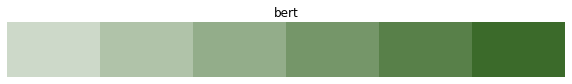

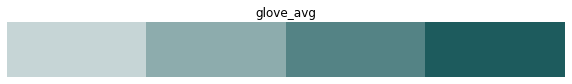

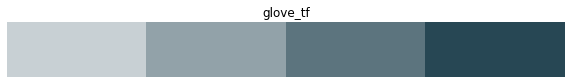

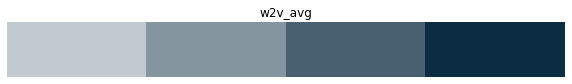

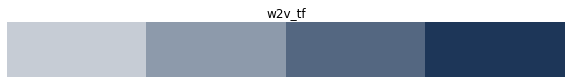

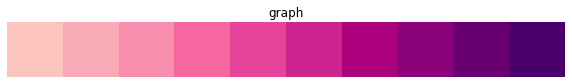

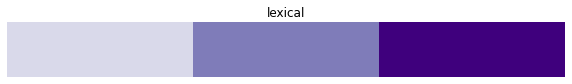

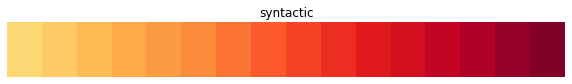

In [30]:
metric_to_color = {}
for group in metric_groups:
    if group == 'LM':
        for model in LM_groups_models:
            tgt_color = model_to_color[model]
            tgt_len = len(LM_groups_models[model])
            palette = sample_categorical_palette(tgt_color, tgt_len)
            visualise_palette(palette, model)
            for i, metric in enumerate(LM_groups_models[model]):
                metric_to_color[metric] = to_hex(palette[i])
    else:
        tgt_plt = group_to_palette[group]
        tgt_len = len(metric_groups[group])
        palette = sample_categorical_palette('', tgt_len, cmap=plt.get_cmap(tgt_plt))
        visualise_palette(palette, group)
        for i, metric in enumerate(metric_groups[group]):
            metric_to_color[metric] = to_hex(palette[i])
        

## Assess task dificulty


for each task - count metrics that perform on it

In [31]:
def CI_does_not_intersect_zero(line):
    return line['CI_low'] * line['CI_high'] > 0

In [32]:
# long_df[~long_df.apply(CI_does_not_intersect_zero, axis=1)]

In [33]:
def perfrom_above_treshold(line, r=0.3, t=0.2, ps_r=0.09):
    if not CI_does_not_intersect_zero(line):
        return False
    elif line['performance_metric'] == 't':
        return True
    elif line['performance_metric'] == 'r' and abs(line['median']) > r:
        return True
    elif line['performance_metric'] == 'ps_r' and abs(line['median']) > ps_r:
        return True
    return False

In [34]:
control_cols = ['mean_sent_len', 'n_sents', 'n_words']

In [35]:
def perfrom_above_baselines(df, lang, metric_name):
    data = df[df['lang'] == lang]
    base_perf = False
    for task in data['task'].unique():
        for outcome in ['t', 'r', 'ps_r']:
            for scale in df['scale'].unique():
                t_data = data[(data['task'] == task) & (data['performance_metric'] == outcome) & (data['scale'] == scale)]
                if len(t_data) == 0:
                    continue
                max_baseline_value = 0
                for col in control_cols:
                    base_val = t_data[t_data['metric_name'] == col]['median'].abs().values[0]
#                     print(base_val)
                    max_baseline_value = max(max_baseline_value, base_val)
                outcome_val = t_data[t_data['metric_name'] == metric_name]['median'].abs().values[0]
                if outcome_val > max_baseline_value:
                    base_perf = True
    return base_perf and perfrom_above_treshold_any(df, lang, metric_name)

In [36]:
def perfrom_above_treshold_any(df, lang, metric_name):
    data = df[(df['metric_name'] == metric_name) & (df['lang'] == lang)]
    return data.apply(perfrom_above_treshold, axis=1).any()

In [37]:
for metric in metric_to_color:
    for lang in ["de", "ru"]:
        print(metric, lang, perfrom_above_baselines(long_df, lang, metric)) 

bert_cgcoh de True
bert_cgcoh ru True
bert_gcoh de False
bert_gcoh ru True
bert_lcoh de False
bert_lcoh ru False
bert_pppl de True
bert_pppl ru True
bert_scoh de True
bert_scoh ru False
bert_sprob de True
bert_sprob ru False
glove_avg_cgcoh de False
glove_avg_cgcoh ru False
glove_avg_gcoh de True
glove_avg_gcoh ru False
glove_avg_lcoh de True
glove_avg_lcoh ru False
glove_avg_scoh de True
glove_avg_scoh ru True
glove_tf_cgcoh de True
glove_tf_cgcoh ru False
glove_tf_gcoh de True
glove_tf_gcoh ru False
glove_tf_lcoh de False
glove_tf_lcoh ru False
glove_tf_scoh de True
glove_tf_scoh ru False
w2v_avg_cgcoh de True
w2v_avg_cgcoh ru False
w2v_avg_gcoh de True
w2v_avg_gcoh ru False
w2v_avg_lcoh de True
w2v_avg_lcoh ru True
w2v_avg_scoh de True
w2v_avg_scoh ru True
w2v_tf_cgcoh de True
w2v_tf_cgcoh ru False
w2v_tf_gcoh de True
w2v_tf_gcoh ru False
w2v_tf_lcoh de True
w2v_tf_lcoh ru False
w2v_tf_scoh de True
w2v_tf_scoh ru True
L1 de True
L1 ru False
L2 de False
L2 ru False
L3 de False
L3 ru 

In [38]:
# long_df['task'].value_counts()

In [39]:
# long_df[long_df[['lang', 'task', 'scale', 'performance_metric', 'metric_group', 'metric_name']].duplicated(keep=False)]

In [40]:
long_df[long_df.apply(perfrom_above_treshold, axis=1)]['task'].value_counts()

task
present      155
chair        109
adventure    106
sportsman    101
anger         94
fear          68
sadness       58
happiness     23
Name: count, dtype: int64

In [41]:
long_df[long_df.apply(perfrom_above_treshold, axis=1) & (long_df["scale"]== "panss_total")]['task'].value_counts()

task
present      20
anger        15
fear         13
chair        12
adventure    10
sportsman    10
sadness      10
happiness     1
Name: count, dtype: int64

In [42]:
best_task = {"ru": "present", "de": "anger"} 

## Plot all metrics on the best task for each language

for the best task, for each langugae 4 x 2 panels - each metric group vs t-test performance and correlation with panss total - three baselines 

In [43]:
def plot_horisontal_ci_ax(df, ax, palette=None, key='median', 
                          xlabel='Mean Value with Confidence Interval', add_zero=True):
    # Add custom error bars based on the confidence intervals
    for i, row in df.iterrows():
        if not palette:
            color = 'skyblue'
        elif isinstance(palette, list):
            color = palette[i]
        elif isinstance(palette, dict):
            color = palette.get(row['metric_name'], 'skyblue')
        ax.errorbar(row[key], row['metric_name'], 
                     xerr=[[abs(row[key] - row['CI_low'])], [abs(row['CI_high'] - row[key])]], 
                     fmt='o', color=color, capsize=0, elinewidth=2)

    # Add labels and title
    if xlabel:
        ax.set_xlabel(xlabel)
    if add_zero:
        ax.axvline(0, color="darkgrey")

In [44]:
def add_baseline_lines(ax, value, add_neg=True, color=None, alpha=1):
    color = color or "lightblue"
    ax.axvline(value, linestyle=':', color=color, alpha=alpha)
    if add_neg:
        ax.axvline(-value, linestyle=':', color=color, alpha=alpha)

In [45]:
def get_data(df, lang, task, metric_group=None, scale='panss_total'):
    if not metric_group:
        return df[(df["lang"] == lang) & (df["task"] == task) & (df["scale"] == scale)]
    else:
        return df[(df["lang"] == lang) & (df["task"] == task) & 
                  (df["scale"] == scale) & (df["metric_group"] == metric_group)]

In [46]:
def add_control_lines(ax, df, lang, task, scale='panss_total', control_cols=control_cols, alpha=1):
    for control_col in control_cols:
        cdata = get_data(df, lang, task, scale=scale)
        control_median = cdata[cdata["metric_name"] == control_col]["median"].values[0]
        control_color = metric_to_color[control_col]
        add_baseline_lines(ax, control_median, color=control_color, alpha=alpha)

In [47]:
# ex = get_data(long_df, "ru", "present", "syntactic")
# fig, axes = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
# ax = axes

# plot_horisontal_ci_ax(ex, ax, palette=metric_to_color, xlabel=None)
# for control_col in control_cols:
#     cdata = get_data(long_df, "ru", "present")
#     control_median = cdata[cdata["metric_name"] == control_col]["median"].values[0]
#     control_color = metric_to_color[control_col]
#     add_baseline_lines(ax, control_median, color=control_color)
# fig.suptitle('Syntactic metrics on russian present task, correlation with PANSS total')

# add_grey(ax)

# # Show the plot
# plt.tight_layout()
# plt.show()

In [48]:
dpi = 300

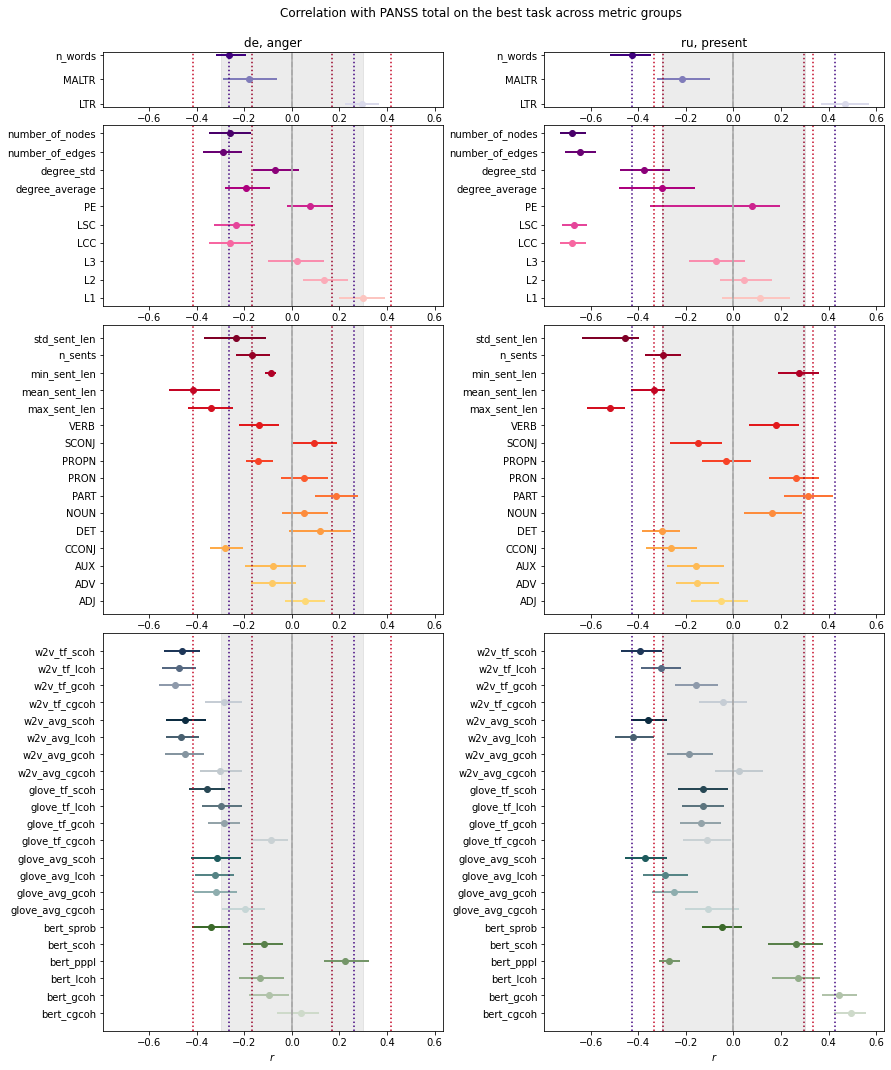

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
plt.subplots_adjust(hspace=0.08, wspace=0.3)

for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        task = best_task[lang]
        data = get_data(long_df, lang, task, metric_group)
        plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
        add_control_lines(ax, long_df, lang, task)
        add_grey(ax)
        ax.xaxis.set_tick_params(labelbottom=True)
        if i == 0:
            ax.set_title(f"{lang}, {task}")
        if i == 3:
            ax.set_xlabel("$r$")

fig.suptitle("Correlation with PANSS total on the best task across metric groups", y=0.915);
plt.savefig(f'{PATH_FIG}panss_total_best_task_all_metrics_across_languages.png', dpi=dpi, bbox_inches = 'tight')
plt.show()


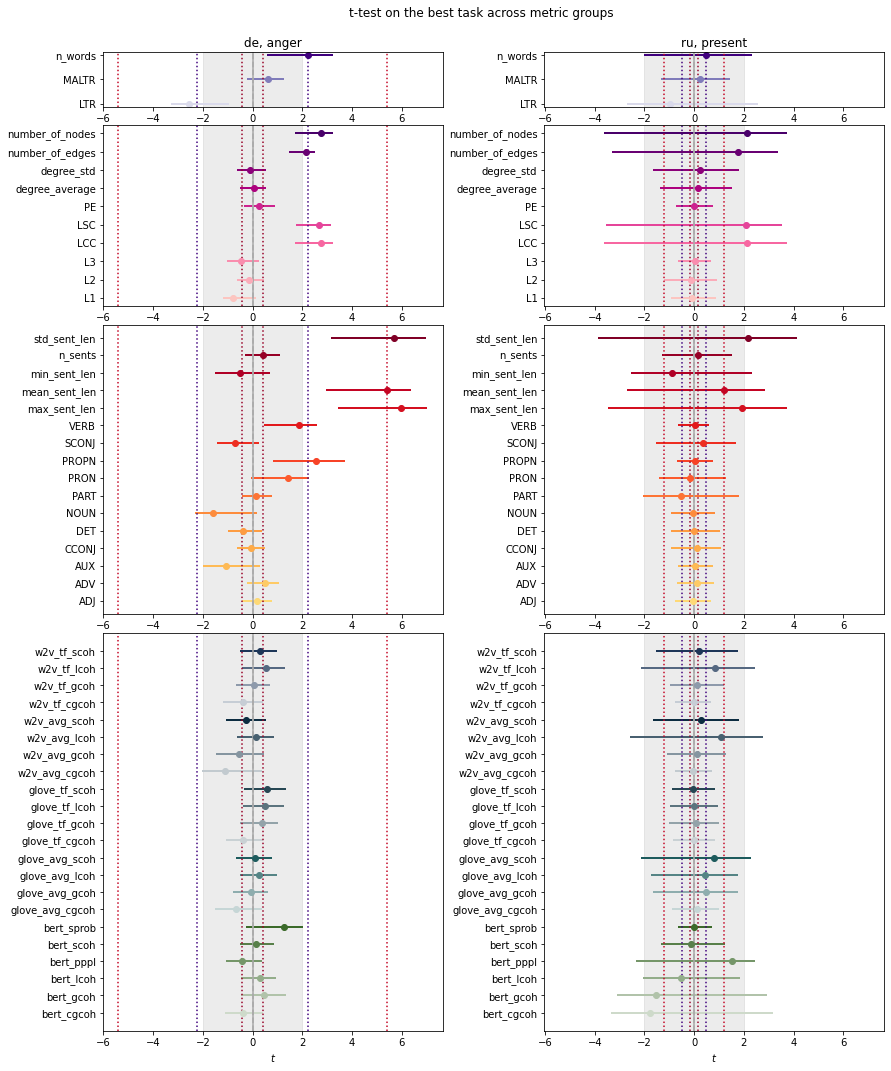

In [50]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
plt.subplots_adjust(hspace=0.08, wspace=0.3)

for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        task = best_task[lang]
        data = get_data(long_df, lang, task, metric_group, scale='group_diff')
        plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
        add_control_lines(ax, long_df, lang, task, scale='group_diff')
        add_grey(ax, r=2)
        ax.xaxis.set_tick_params(labelbottom=True)
        if i == 0:
            ax.set_title(f"{lang}, {task}")
        if i == 3:
            ax.set_xlabel("$t$")

fig.suptitle("t-test on the best task across metric groups", y=0.915);
plt.savefig(f'{PATH_FIG}t-test_best_task_all_metrics_across_languages.png', dpi=dpi, bbox_inches = 'tight')
plt.show()

In [51]:
def mean_task_performance(df, metric_name, lang, scale, key='median', abs_=True):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)][key]
    if abs_:
        data = data.abs()
    return np.nanmean(data)

In [52]:
def SE_low_high_task_performance(df, metric_name, lang, scale, key='median', abs_=True):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)][key]
    if abs_:
        data = data.abs()
    se = np.std(data) / np.sqrt(len(data))
    return np.nanmean(data) - se,  np.nanmean(data) + se

In [53]:
def mean_CI_low_high_task_performance(df, metric_name, lang, scale, key='median', abs_=True):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)]
    if abs_:
        data = data.abs()
    CI_low, CI_high = np.nanmean(data['CI_low']), np.nanmean(data['CI_high'])
    return CI_low, CI_high

In [54]:
# fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
# plt.subplots_adjust(hspace=0.08, wspace=0.3)

# for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
#     for j, lang in enumerate(["de", "ru"]):
#         ax = axes[i, j]
#         for task in long_df[long_df["lang"] == lang]["task"].unique():
#             data = get_data(long_df, lang, task, metric_group)
#             plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
#             add_control_lines(ax, long_df, lang, task)
#         add_grey(ax)
#         ax.xaxis.set_tick_params(labelbottom=True)
#         if i == 0:
#             ax.set_title(f"{lang}, {task}")
#         if i == 3:
#             ax.set_xlabel("$r$")

# fig.suptitle("Correlation with PANSS total on all tasks across metric groups", y=0.915);
# plt.show()

# # plt.savefig(f'{PATH_FIG}panss_total_best_task_all_metrics_across_languages.png', dpi=dpi, bbox_inches = 'tight')

In [55]:
mean_data = []
for lang in ["de", "ru"]:
    for metric_name in metric_to_color:
        for scale in ['panss_total', 'group_diff']:
            perfromance_metric = long_df[long_df['scale'] == scale]['performance_metric'].unique()[0]
            metric_group = long_df[long_df['metric_name'] == metric_name]["metric_group"].values[0]
            mean = mean_task_performance(long_df, metric_name, lang, scale, abs_=False)
            mean_SE_low, mean_SE_high = SE_low_high_task_performance(long_df, metric_name, lang, scale, abs_=False)
            mean_CI_low, mean_CI_high = mean_CI_low_high_task_performance(long_df, metric_name, lang, scale, abs_=False)
            mean_data.append((lang, 'mean', scale, perfromance_metric, 
                              metric_name, metric_group, mean, 
                              mean_CI_low, mean_CI_high, mean_SE_low, mean_SE_high))

In [56]:
task_mean_df = pd.DataFrame(mean_data, columns=['lang', 'task', 'scale', 'perfromance_metric', 
                                                'metric_name', 'metric_group', 'median', 
                                                'CI_low', 'CI_high', 'SE_low', 'SE_high'])

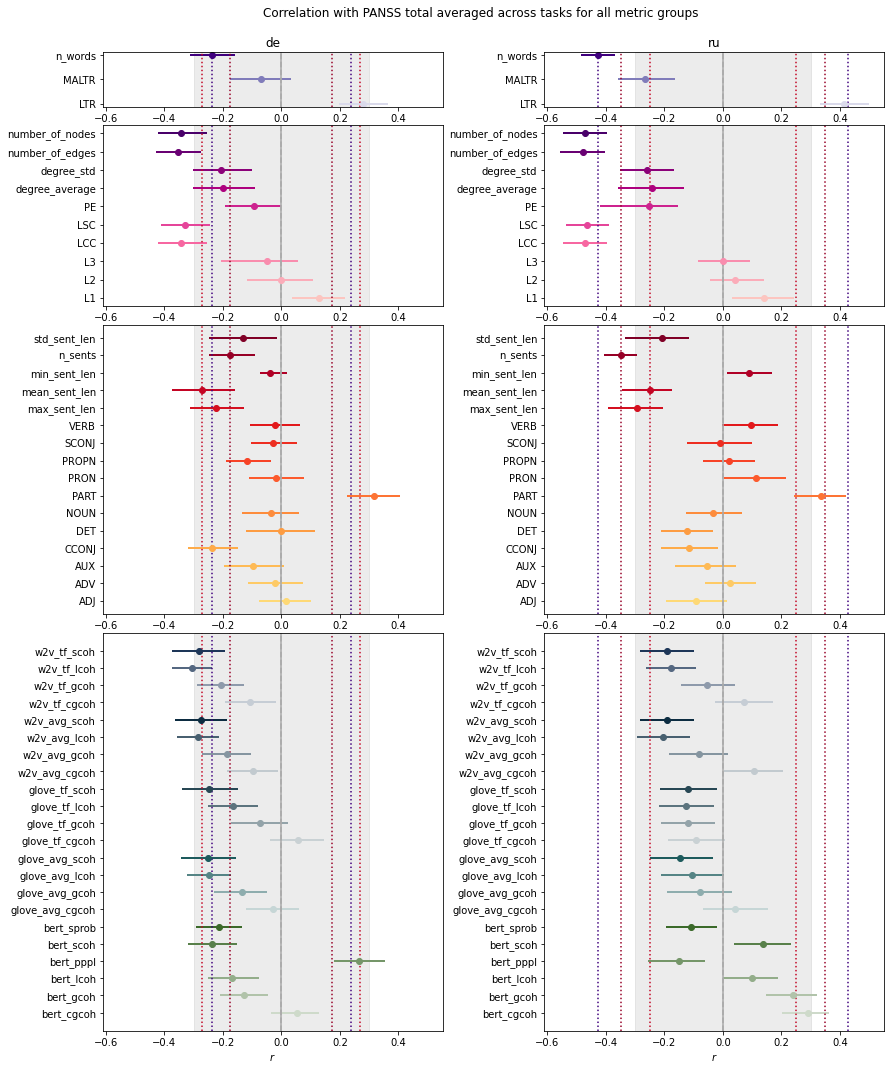

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
plt.subplots_adjust(hspace=0.08, wspace=0.3)

for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        data = get_data(task_mean_df, lang, 'mean', metric_group)
        plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
        add_control_lines(ax, task_mean_df, lang, 'mean')
        add_grey(ax)
        ax.xaxis.set_tick_params(labelbottom=True)
        if i == 0:
            ax.set_title(f"{lang}")
        if i == 3:
            ax.set_xlabel("$r$")

fig.suptitle("Correlation with PANSS total averaged across tasks for all metric groups", y=0.915);
plt.savefig(f'{PATH_FIG}panss_total_mean_task_all_metrics_across_languages.png', dpi=dpi, bbox_inches = 'tight')
plt.show()

In [58]:
long_df[(long_df['lang'] == 'ru') & (long_df['scale'] == 'group_diff') & (long_df['median'].abs() > 2)]

,lang,task,scale,performance_metric,metric_group,metric_name,median,mean,CI_low,CI_high,...,corr_mean_sent_len_CI_low,corr_mean_sent_len_CI_high,corr_n_sents_median,corr_n_sents_mean,corr_n_sents_CI_low,corr_n_sents_CI_high,corr_n_words_median,corr_n_words_mean,corr_n_words_CI_low,corr_n_words_CI_high
229,ru,adventure,group_diff,t,graph,LCC,2.391363,0.621433,-3.479249,4.053571,...,0.481363,0.567005,0.464098,0.463874,0.418868,0.508877,0.620786,0.620163,0.584993,0.654975
230,ru,adventure,group_diff,t,graph,LSC,2.246624,0.580586,-3.318587,3.780654,...,0.398040,0.506240,0.476906,0.479101,0.436444,0.521077,0.609894,0.611776,0.577852,0.643159
235,ru,adventure,group_diff,t,graph,number_of_nodes,2.391363,0.621433,-3.479249,4.053571,...,0.481363,0.567005,0.464098,0.463874,0.418868,0.508877,0.620786,0.620163,0.584993,0.654975
237,ru,adventure,group_diff,t,lexical,MALTR,2.194930,0.482879,-2.929252,3.166436,...,0.287084,0.399606,-0.207287,-0.210428,-0.287321,-0.134594,-0.054055,-0.057436,-0.142477,0.031825
238,ru,adventure,group_diff,t,lexical,n_words,3.213784,0.751942,-3.808728,4.343612,...,0.236602,0.364692,0.906584,0.904342,0.888983,0.922169,NaN,NaN,NaN,NaN
253,ru,adventure,group_diff,t,syntactic,n_sents,2.646743,0.636606,-3.233283,3.663491,...,-0.140435,-0.021500,NaN,NaN,NaN,NaN,0.906584,0.904342,0.888983,0.922169
642,ru,chair,group_diff,t,graph,number_of_edges,2.231427,0.000130,-3.989663,3.939779,...,0.436758,0.522037,0.493635,0.538749,0.450540,0.659853,0.648220,0.658868,0.605426,0.714452
644,ru,chair,group_diff,t,lexical,LTR,-3.325996,-0.016267,-5.738448,5.772433,...,-0.514487,-0.399295,-0.649791,-0.654050,-0.687388,-0.618735,-0.783210,-0.783244,-0.800037,-0.766069
646,ru,chair,group_diff,t,lexical,n_words,3.266403,0.147533,-4.998908,5.089219,...,0.286811,0.490631,0.903033,0.900296,0.884210,0.921858,NaN,NaN,NaN,NaN
661,ru,chair,group_diff,t,syntactic,n_sents,2.295449,0.124596,-3.612384,3.784091,...,-0.073042,0.058438,NaN,NaN,NaN,NaN,0.903033,0.900296,0.884210,0.921858


In [59]:
task_mean_df[(task_mean_df['lang'] == 'de') & (task_mean_df['scale'] == 'panss_total') & (task_mean_df['metric_name'] == 'LCC')]

,lang,task,scale,perfromance_metric,metric_name,metric_group,median,CI_low,CI_high,SE_low,SE_high
50,de,mean,panss_total,r,LCC,graph,-0.341636,-0.42197,-0.254917,-0.390116,-0.293157


In [60]:
task_mean_df[(task_mean_df['lang'] == 'de') & (task_mean_df['scale'] == 'panss_total') & (task_mean_df['metric_name'] == 'LSC')]

,lang,task,scale,perfromance_metric,metric_name,metric_group,median,CI_low,CI_high,SE_low,SE_high
52,de,mean,panss_total,r,LSC,graph,-0.328254,-0.410851,-0.244181,-0.380944,-0.275564


In [61]:
np.mean([-0.341636, -0.328254])

-0.334945

In [62]:
task_mean_df[(task_mean_df['lang'] == 'ru') & (task_mean_df['scale'] == 'panss_total') & (task_mean_df['metric_name'] == 'LCC')]

,lang,task,scale,perfromance_metric,metric_name,metric_group,median,CI_low,CI_high,SE_low,SE_high
152,ru,mean,panss_total,r,LCC,graph,-0.472083,-0.545502,-0.396638,-0.53208,-0.412087


In [63]:
task_mean_df[(task_mean_df['lang'] == 'ru') & (task_mean_df['scale'] == 'panss_total') & (task_mean_df['metric_name'] == 'LSC')]

,lang,task,scale,perfromance_metric,metric_name,metric_group,median,CI_low,CI_high,SE_low,SE_high
154,ru,mean,panss_total,r,LSC,graph,-0.464262,-0.536659,-0.389553,-0.526529,-0.401995


In [64]:
np.mean([-0.472083, -0.464262])

-0.4681725

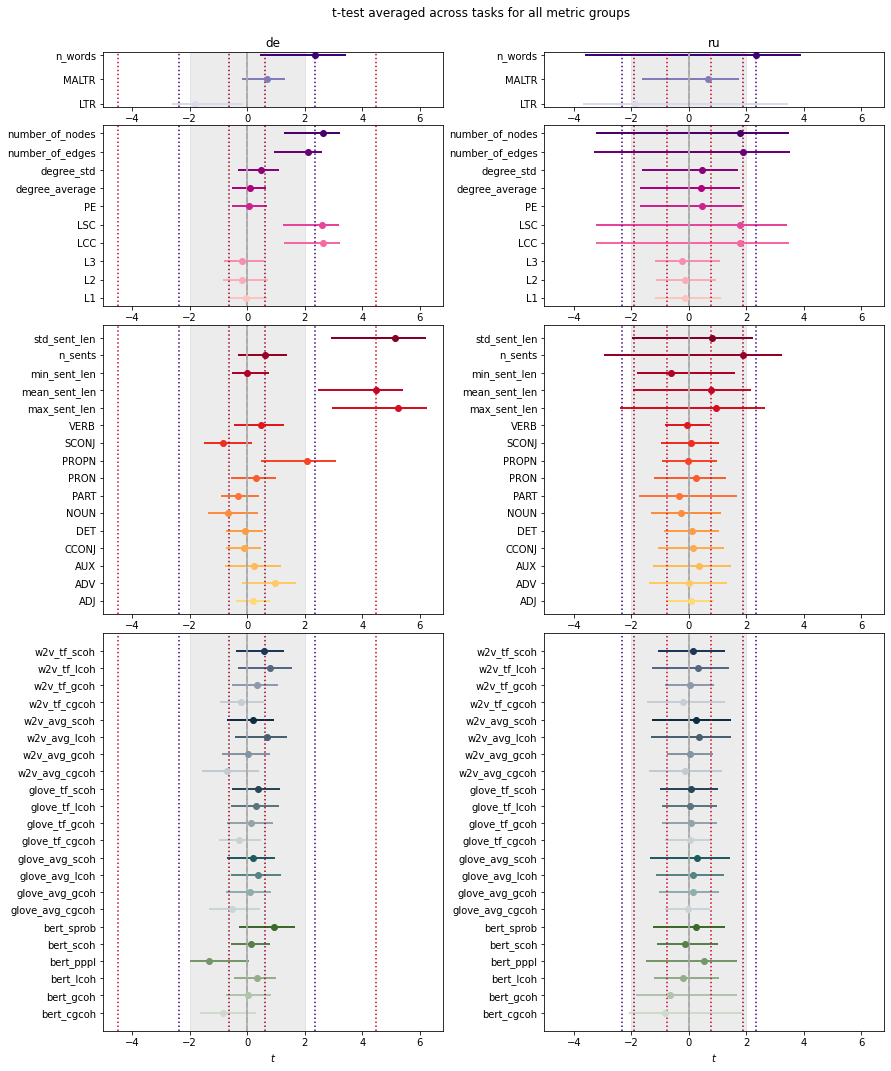

In [65]:
fig, axes = plt.subplots(4, 2, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [3, 10, 16, 22]})
plt.subplots_adjust(hspace=0.08, wspace=0.3)

for i, metric_group in enumerate(['lexical', 'graph', 'syntactic', 'LM']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        data = get_data(task_mean_df, lang, 'mean', metric_group, scale='group_diff')
        plot_horisontal_ci_ax(data, ax, palette=metric_to_color, xlabel=None)
        add_control_lines(ax, task_mean_df, lang, 'mean', scale='group_diff')
        add_grey(ax, r=2)
        ax.xaxis.set_tick_params(labelbottom=True)
        if i == 0:
            ax.set_title(f"{lang}")
        if i == 3:
            ax.set_xlabel("$t$")

fig.suptitle("t-test averaged across tasks for all metric groups", y=0.915);
plt.savefig(f'{PATH_FIG}t-test_mean_task_all_metrics_across_languages.png', dpi=300, bbox_inches = 'tight')
plt.show()

## Correlation of performance with correlation with verbosity

each language, each task: 3 baselines by 2 t-test and panss total performance - scatter plot + correlation line: performace vs corr baseline - color metrics by group

In [66]:
def corr_nan(df, col1, col2, abs_=True):
    dropped_c = df.dropna(subset=[col1, col2])
    c1 = abs(dropped_c[col1]) if abs_ else dropped_c[col1]
    c2 = abs(dropped_c[col2]) if abs_ else dropped_c[col2]
    r_c = stats.pearsonr(c1, c2)[0]
    return r_c

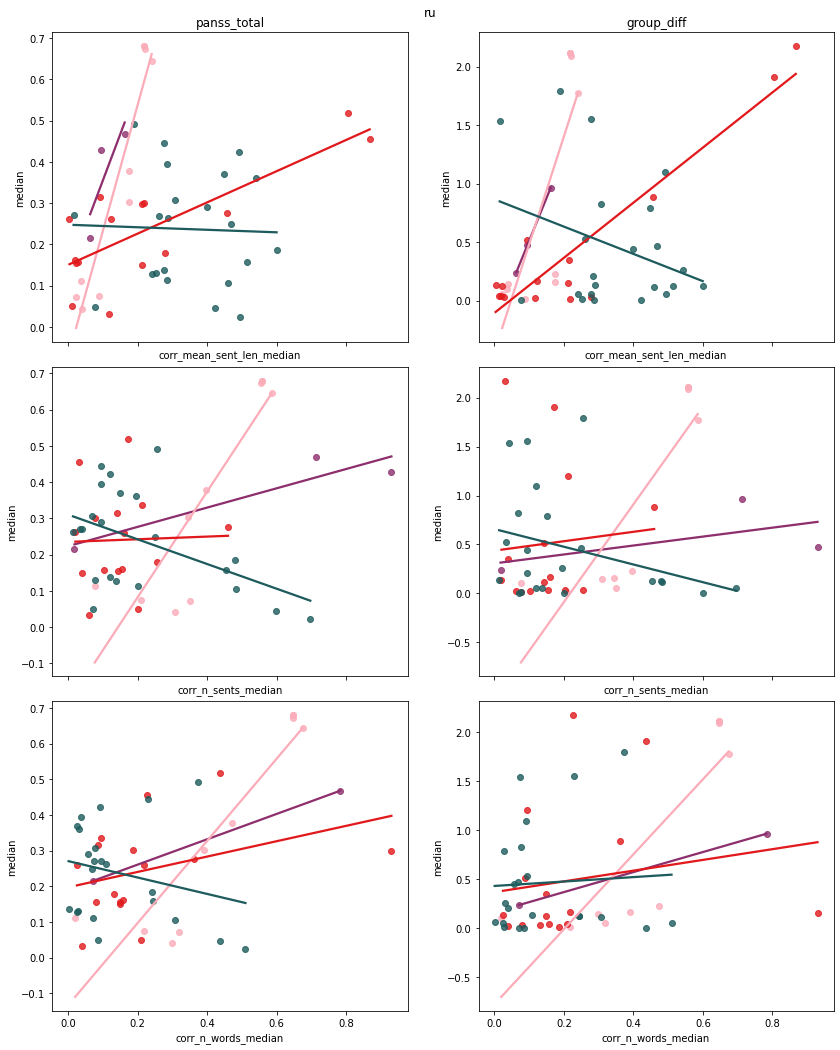

In [67]:
lang="ru"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        for metric_group in ['lexical', 'graph', 'syntactic', 'LM']:
            data = get_data(long_df, lang, task, metric_group, scale=scale)
            data = data[data["metric_name"] != control_col]
            sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), 
                        color=group_to_color[metric_group], ax=ax, ci=None)
#         data = get_data(long_df, lang, task, scale='group_diff')
#         data = data[data["metric_name"] != control_col]
#         sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

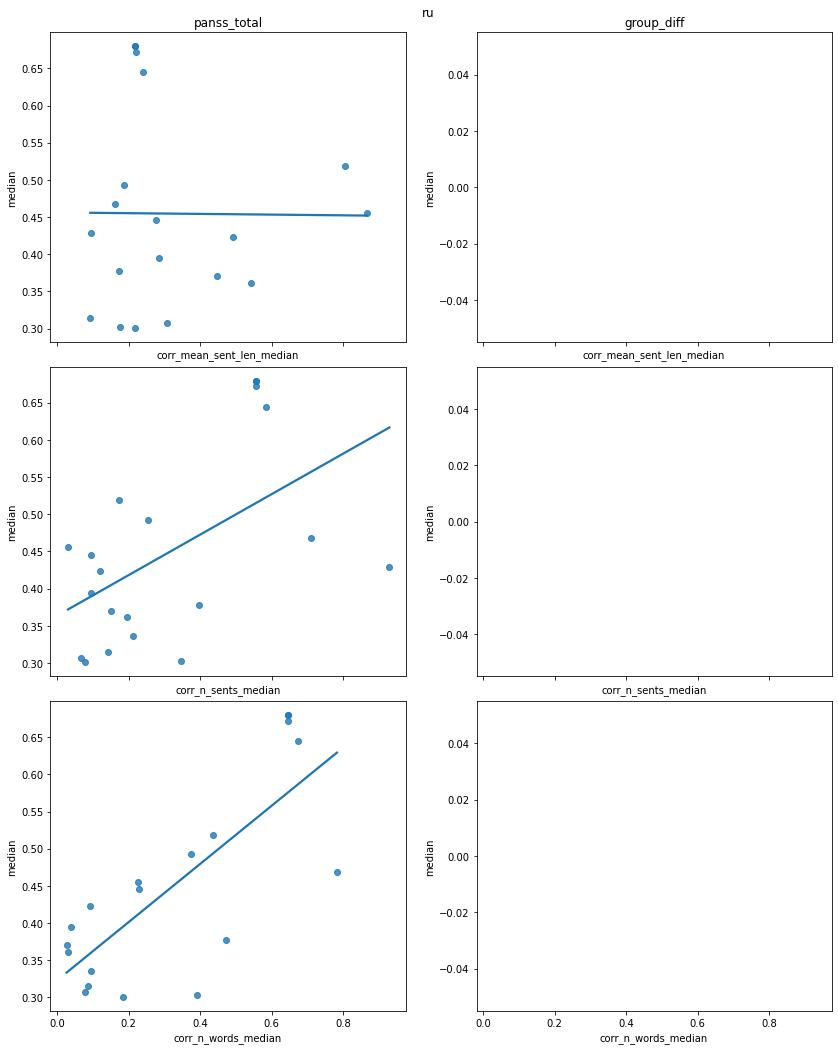

In [68]:
lang = "ru"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        data = get_data(long_df, lang, task, scale=scale)
        data = data[(data["metric_name"] != control_col) & data.apply(perfrom_above_treshold, axis=1)]
        sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

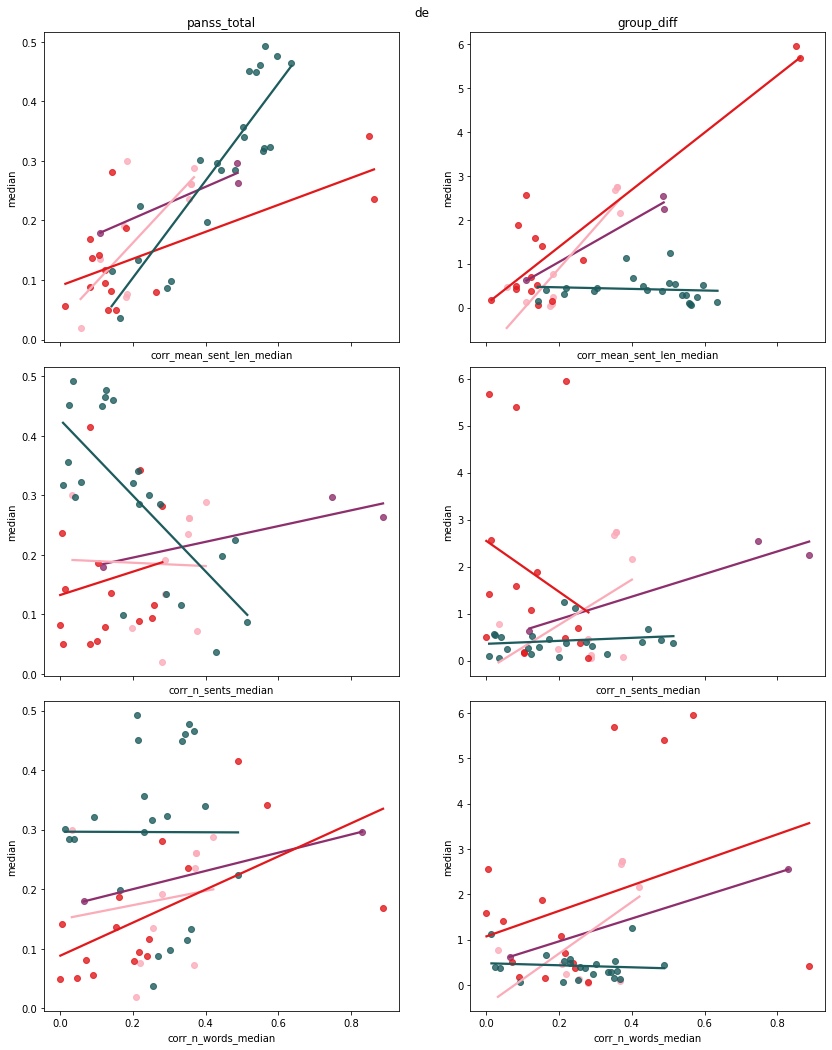

In [69]:
lang = "de"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        for metric_group in ['lexical', 'graph', 'syntactic', 'LM']:
            data = get_data(long_df, lang, task, metric_group, scale=scale)
            data = data[data["metric_name"] != control_col]
            sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), 
                        color=group_to_color[metric_group], ax=ax, ci=None)
#         data = get_data(long_df, lang, task, scale='group_diff')
#         data = data[data["metric_name"] != control_col]
#         sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

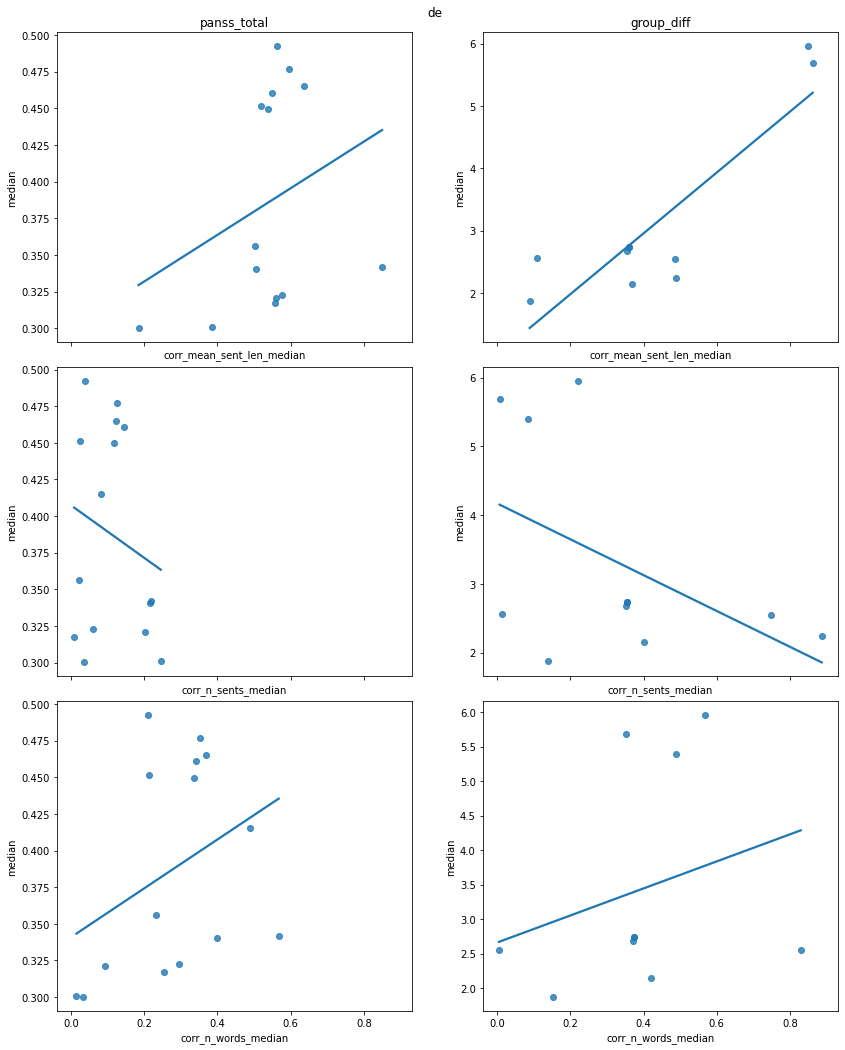

In [70]:
lang = "de"
fig, axes = plt.subplots(3, 2, figsize=(14, 18), sharex=True)
plt.subplots_adjust(hspace=0.08) #, wspace=0.3)

for i, control_col in  enumerate(control_cols):
    for j, scale in enumerate(['panss_total', 'group_diff']):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(scale)
        task = best_task[lang]
        data = get_data(long_df, lang, task, scale=scale)
        data = data[(data["metric_name"] != control_col) & data.apply(perfrom_above_treshold, axis=1)]
        sns.regplot(y=abs(data['median']), x=abs(data[f'corr_{control_col}_median']), ax=ax, ci=None)
fig.suptitle(lang, y=0.9);

## Best metrics perform across tasks
difference between tasks: SD(performance) / (mean task performance) - scatter vs mean task performance on t-test and panss total - color metrics by group

In [71]:
def diff_task_performance(df, metric_name, lang, scale):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)]['median'].abs()
    return np.std(data) / np.mean(data)

In [72]:
def best_task_performance(df, metric_name, lang, scale):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['scale'] == scale)]['median'].abs()
    return np.nanmax(data)

In [73]:
dict_diff = {"group": [], 
             "diff_group_diff_de": [], "diff_group_diff_ru": [], 
             "diff_panss_total_de": [], "diff_panss_total_ru": [],
             "diff_ps_r_dep.severity_ru": [],
             
             "group_diff_de": [], "group_diff_ru": [], 
             "panss_total_de": [], "panss_total_ru": [],
             "ps_r_dep.severity_ru": [], 
             
             "best_group_diff_de": [], "best_group_diff_ru": [], 
             "best_panss_total_de": [], "best_panss_total_ru": [],
             "best_ps_r_dep.severity_ru": []}
for lang in ["de", "ru"]:
    for metric_name in metric_to_color:
        for scale in ['panss_total', 'group_diff', "ps_r_dep.severity"]:
            if lang == 'de' and scale == "ps_r_dep.severity":
                continue
            diff = diff_task_performance(long_df, metric_name, lang, scale)
            mean = mean_task_performance(long_df, metric_name, lang, scale)
            best = best_task_performance(long_df, metric_name, lang, scale)
            dict_diff[f"diff_{scale}_{lang}"].append(diff)
            if lang == "ru" and scale == "group_diff":
                dict_diff["group"].append(long_df[long_df['metric_name'] == metric_name]["metric_group"].values[0])
            dict_diff[f"{scale}_{lang}"].append(mean)
            dict_diff[f"best_{scale}_{lang}"].append(best)

In [74]:
diff_df = pd.DataFrame.from_dict(dict_diff)
diff_df.index = list(metric_to_color.keys())

In [75]:
slice_diff_df = diff_df[[f"diff_panss_total_de", f"panss_total_de"]]

In [76]:
# def get_coefficient(x_name, y_name, x, y):
#     df = pd.DataFrame({x_name: x, y_name: y})
#     df = sm.add_constant(df, prepend=False)
#     mod = sm.OLS(df[y_name], df[x_name])
#     res = mod.fit()
#     print(f'{x_name}, {y_name}, {res.rsquared:.2f}, {res.pvalues[x_name]:.5f}')
# #     print(res.summary())
#     return res.rsquared

In [77]:
def get_coefficient(x_name, y_name, x, y):
    df = pd.DataFrame({x_name: x, y_name: y})
    df.dropna(inplace=True)
    r, p = stats.pearsonr(df[x_name], df[y_name])
    print(f'{x_name}, {y_name}, {r:.2f}, {p:.5f}')
    return r

In [78]:
get_coefficient(f"panss_total_de", f"diff_panss_total_de", diff_df[f"panss_total_de"], diff_df[f"diff_panss_total_de"])

panss_total_de, diff_panss_total_de, -0.56, 0.00002


-0.5609499458361692

panss_total_ru, diff_panss_total_ru, -0.46, 0.00063
group_diff_ru, diff_group_diff_ru, -0.51, 0.00012
ps_r_dep.severity_ru, diff_ps_r_dep.severity_ru, -0.46, 0.00063


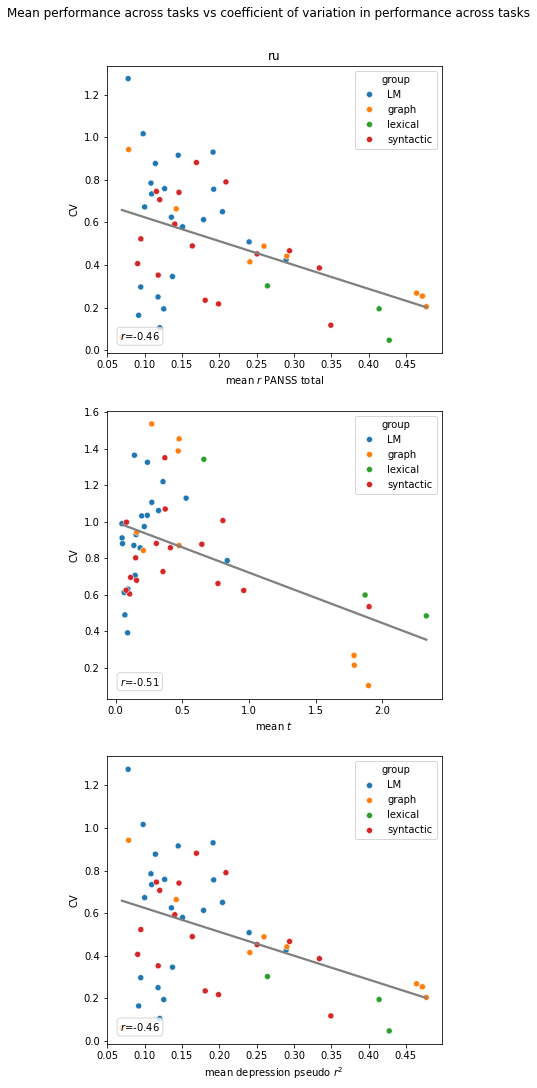

In [79]:
fig, axes = plt.subplots(3, 1, figsize=(6, 18))
for i, scale in enumerate(['panss_total', 'group_diff', 'ps_r_dep.severity']):
    lang = 'ru'
    ax = axes[i]
    if i == 0:
        ax.set_title(lang)
    y_name, x_name = f"diff_{scale}_{lang}", f"{scale}_{lang}"
    y, x = diff_df[y_name], diff_df[x_name]
    sns.scatterplot(y=y, x=x, hue=diff_df["group"], ax=ax)
    sns.regplot(y=y, x=x, 
                ci=None, scatter=False, color='grey', ax=ax)
    ax.set_ylabel('CV')
    label = {'panss_total': 'mean $r$ PANSS total',
             'group_diff': "mean $t$",
             'ps_r_dep.severity': 'mean depression pseudo $r^2$'}.get(scale, '...')
    coef = get_coefficient(x_name, y_name, x, y)
    ax.text(0.04, 0.08,
            f'$r$={coef:.2f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
    ax.set_xlabel(label)
fig.suptitle("Mean performance across tasks vs coefficient of variation in performance across tasks", y=0.925);
# plt.savefig(f'{PATH_FIG}performance_vs_CV_across_tasks.png', dpi=dpi, bbox_inches = 'tight')

panss_total_de, diff_panss_total_de, -0.56, 0.00002
panss_total_ru, diff_panss_total_ru, -0.46, 0.00063
group_diff_de, diff_group_diff_de, -0.62, 0.00000
group_diff_ru, diff_group_diff_ru, -0.51, 0.00012


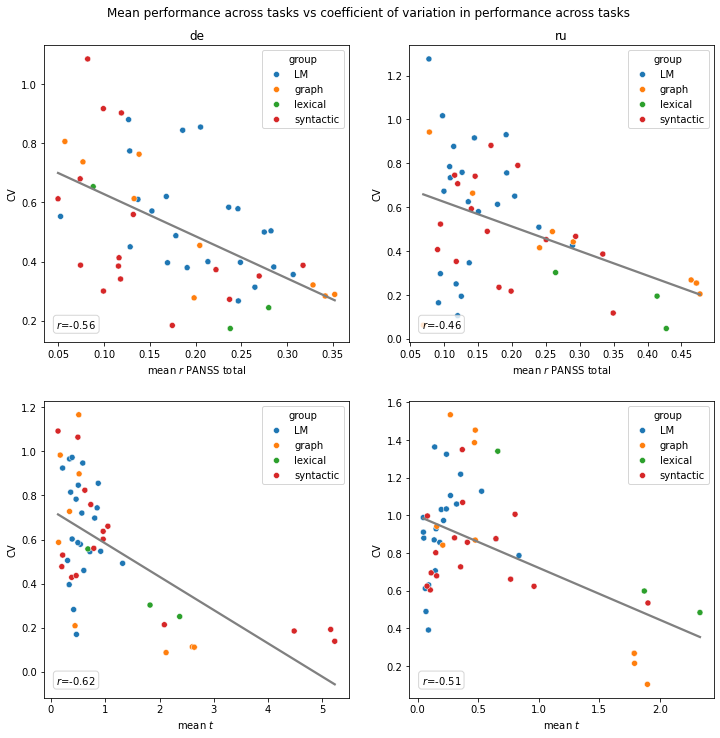

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, scale in enumerate(['panss_total', 'group_diff']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(lang)
        y_name, x_name = f"diff_{scale}_{lang}", f"{scale}_{lang}"
        y, x = diff_df[y_name], diff_df[x_name]
        sns.scatterplot(y=y, x=x, hue=diff_df["group"], ax=ax)
        sns.regplot(y=y, x=x, 
                    ci=None, scatter=False, color='grey', ax=ax)
        coef = get_coefficient(x_name, y_name, x, y)
        ax.text(0.04, 0.08,
                f'$r$={coef:.2f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
        ax.set_ylabel('CV')
        label = 'mean $r$ PANSS total' if i == 0 else "mean $t$"
        ax.set_xlabel(label)
fig.suptitle("Mean performance across tasks vs coefficient of variation in performance across tasks", y=0.925);
plt.savefig(f'{PATH_FIG}performance_vs_CV_across_tasks.png', dpi=dpi, bbox_inches = 'tight')

best_panss_total_de, diff_panss_total_de, -0.18, 0.19484
best_panss_total_ru, diff_panss_total_ru, -0.11, 0.45677
best_group_diff_de, diff_group_diff_de, -0.48, 0.00035
best_group_diff_ru, diff_group_diff_ru, -0.21, 0.13992


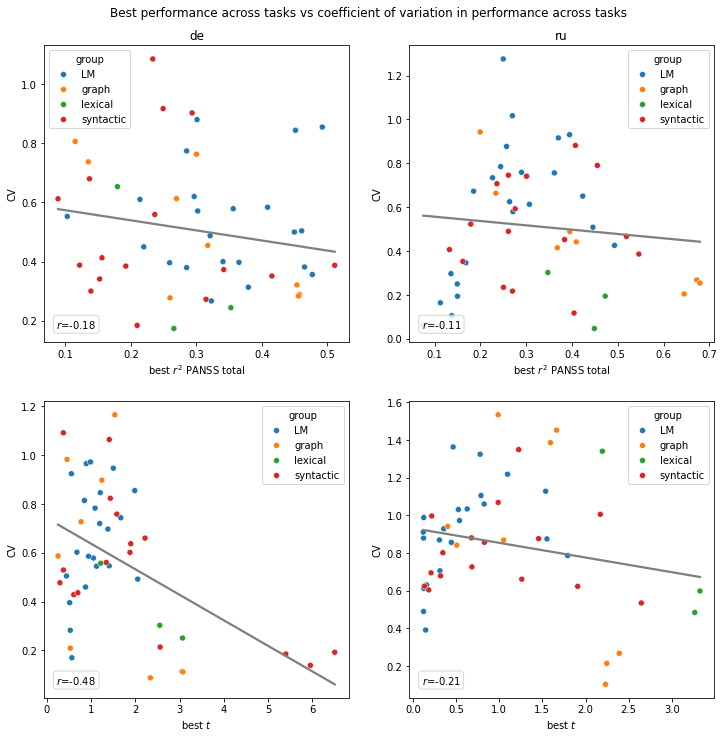

In [81]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, scale in enumerate(['panss_total', 'group_diff']):
    for j, lang in enumerate(["de", "ru"]):
        ax = axes[i, j]
        if i == 0:
            ax.set_title(lang)
        y_name, x_name = f"diff_{scale}_{lang}", f"best_{scale}_{lang}"
        y, x = diff_df[y_name], diff_df[x_name]
        sns.scatterplot(y=y, x=x, hue=diff_df["group"], ax=ax)
        sns.regplot(y=y, x=x, 
                    ci=None, scatter=False, color='grey', ax=ax)
        ax.set_ylabel('CV')
        coef = get_coefficient(x_name, y_name, x, y)
        ax.text(0.04, 0.08,
                f'$r$={coef:.2f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
        label = 'best $r^2$ PANSS total' if i == 0 else "best $t$"
        ax.set_xlabel(label)
fig.suptitle("Best performance across tasks vs coefficient of variation in performance across tasks", y=0.925);
plt.savefig(f'{PATH_FIG}best_performance_vs_CV_across_tasks.png', dpi=dpi, bbox_inches = 'tight')

## Best metrics perform across scales
difference between scales: SD(performance) / (mean scale performance) - scatter vs mean scale performance on t-test and - color metrics by group

normalize each scale performance z transform ((val) - mean(vals)) / std(vals)

In [82]:
def normalize_scale_values(df, scale, lang, task):
    data = df[(df['lang'] == lang) & (df['scale'] == scale) & (df['task'] == task)]['median'].values
    return (data - np.nanmean(data)) / np.nanstd(data)

In [83]:
long_df["normalized_median"] = np.nan

In [84]:
for lang in ["de", "ru"]:
    for task in long_df[long_df["lang"] == lang]["task"].unique():
        for scale in long_df[long_df["lang"] == lang]["scale"].unique():
            vals = normalize_scale_values(long_df, scale, lang, task)
            long_df.loc[(long_df["lang"] == lang) 
                    & (long_df["task"] == task) 
                    & (long_df["scale"] == scale), "normalized_median"] = vals

In [85]:
def diff_scale_performance(df, metric_name, lang, task):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['task'] == task)]['normalized_median'].abs()
    return np.nanstd(data) / np.nanmean(data)

In [86]:
def mean_scale_performance(df, metric_name, lang, task):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['task'] == task)]['normalized_median'].abs()
    return np.nanmean(data)

In [87]:
def max_scale_performance(df, metric_name, lang, task):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name) & (df['task'] == task)]['normalized_median'].abs()
    return np.nanmax(data)

In [88]:
def diff_max_mean_task_scale_performance(df, metric_name, lang):
    data = df[(df['lang'] == lang) & (df['metric_name'] == metric_name)]
    ress = []
    for task in data['task'].unique():
        ress.append(np.nanmean(data[data['task'] == task]['normalized_median'].abs()))
    return np.nanstd(ress) / np.nanmean(ress), np.nanmax(ress), np.nanmean(ress)

In [89]:
dict_diff_ = {"group": [], 
             'diff_de': [], 'diff_ru': [],
             'best_perf_de': [], 'best_perf_ru': [],
              'perf_de': [], 'perf_ru': []
             }


for lang in ["de", "ru"]:
    for metric_name in metric_to_color:
        diff, best, mean = diff_max_mean_task_scale_performance(long_df, metric_name, lang)
        if lang == "de":
            dict_diff_["group"].append(long_df[long_df['metric_name'] == metric_name]["metric_group"].values[0])
        dict_diff_[f"diff_{lang}"].append(diff)
        dict_diff_[f"best_perf_{lang}"].append(best)
        dict_diff_[f"perf_{lang}"].append(mean)

/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_3417/399261623.py:5: RuntimeWarning: Mean of empty slice
  ress.append(np.nanmean(data[data['task'] == task]['normalized_median'].abs()))


In [90]:
diff_df_ = pd.DataFrame.from_dict(dict_diff_)
diff_df_.index = list(metric_to_color.keys())

perf_de, diff_de, -0.31, 0.02454
perf_ru, diff_ru, -0.48, 0.00039


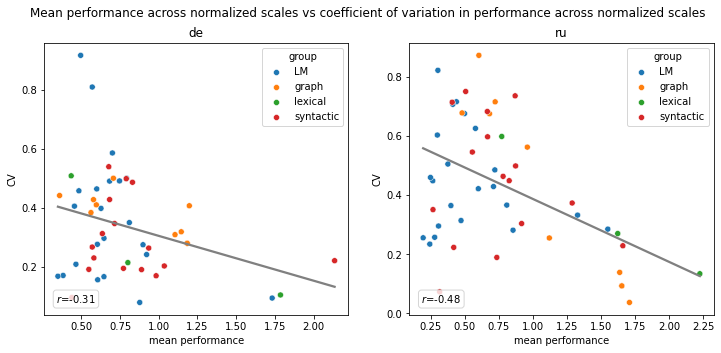

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for j, lang in enumerate(["de", "ru"]):
    task = long_df[long_df["lang"] == lang]["task"].unique()
    ax = axes[j]
    ax.set_title(lang)
    y_name, x_name = f"diff_{lang}", f"perf_{lang}"
    y, x = diff_df_[y_name], diff_df_[x_name]
    sns.scatterplot(y=y, x=x, hue=diff_df_["group"], ax=ax)
    sns.regplot(y=y, x=x, 
                ci=None, scatter=False, color='grey', ax=ax)
    coef = get_coefficient(x_name, y_name, x, y)
    ax.text(0.04, 0.08,
            f'$r$={coef:.2f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
    ax.set_ylabel('CV')
    ax.set_xlabel(f'mean performance')
fig.suptitle("Mean performance across normalized scales vs coefficient of variation in performance across normalized scales");
plt.savefig(f'{PATH_FIG}mean_performance_vs_CV_across_normalized_scales_task_averaged.png', dpi=dpi, bbox_inches = 'tight')

best_perf_de, diff_de, 0.08, 0.56537
best_perf_ru, diff_ru, -0.13, 0.36241


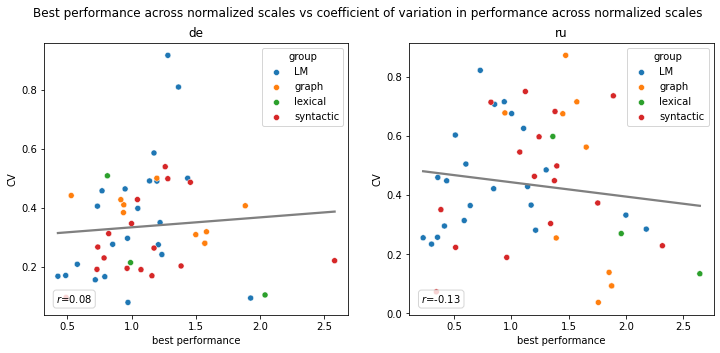

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for j, lang in enumerate(["de", "ru"]):
    task = long_df[long_df["lang"] == lang]["task"].unique()
    ax = axes[j]
    ax.set_title(lang)
    y_name, x_name = f"diff_{lang}", f"best_perf_{lang}"
    y, x = diff_df_[y_name], diff_df_[x_name]
    sns.scatterplot(y=y, x=x, hue=diff_df_["group"], ax=ax)
    sns.regplot(y=y, x=x, 
                ci=None, scatter=False, color='grey', ax=ax)
    coef = get_coefficient(x_name, y_name, x, y)
    ax.text(0.04, 0.08,
            f'$r$={coef:.2f}', transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
    ax.set_ylabel('CV')
    ax.set_xlabel(f'best performance')
fig.suptitle("Best performance across normalized scales vs coefficient of variation in performance across normalized scales");
plt.savefig(f'{PATH_FIG}best_performance_vs_CV_across_normalized_scales_task_averaged.png', dpi=dpi, bbox_inches = 'tight')

In [93]:
dict_diff_ = {"group": [], 
             'diff_anger_de': [], 'diff_fear_de': [],
             'diff_happiness_de': [], 'diff_sadness_de': [],
             'diff_adventure_ru': [], 'diff_chair_ru': [],
             'diff_present_ru': [], 'diff_sportsman_ru': [],
             
             'perf_anger_de': [], 'perf_fear_de': [],
             'perf_happiness_de': [], 'perf_sadness_de': [], 
             
             'perf_adventure_ru': [], 'perf_chair_ru': [], 
             'perf_present_ru': [], 'perf_sportsman_ru': [],
             
             'best_perf_anger_de': [], 'best_perf_fear_de': [],
             'best_perf_happiness_de': [], 'best_perf_sadness_de': [], 
             
             'best_perf_adventure_ru': [], 'best_perf_chair_ru': [], 
             'best_perf_present_ru': [], 'best_perf_sportsman_ru': []}


for lang in ["de", "ru"]:
    for metric_name in metric_to_color:
        for task in long_df[long_df["lang"] == lang]["task"].unique():
            diff = diff_scale_performance(long_df, metric_name, lang, task)
            mean = mean_scale_performance(long_df, metric_name, lang, task)
            best = max_scale_performance(long_df, metric_name, lang, task)
            dict_diff_[f"diff_{task}_{lang}"].append(diff)
            if lang == "de" and task == "anger":
                dict_diff_["group"].append(long_df[long_df['metric_name'] == metric_name]["metric_group"].values[0])
            dict_diff_[f"perf_{task}_{lang}"].append(mean)
            dict_diff_[f"best_perf_{task}_{lang}"].append(best)

/Users/galina.ryazanskaya/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/1l/2khv4cgj7xs0zrm9hnl_yrzh0000gn/T/ipykernel_3417/317686383.py:3: RuntimeWarning: Mean of empty slice
  return np.nanstd(data) / np.nanmean(data)


In [94]:
diff_df_ = pd.DataFrame.from_dict(dict_diff_)
diff_df_.index = list(metric_to_color.keys())

perf_anger_de, diff_anger_de, -0.54, 0.00005
perf_adventure_ru, diff_adventure_ru, -0.66, 0.00000
perf_fear_de, diff_fear_de, -0.33, 0.01967
perf_chair_ru, diff_chair_ru, -0.52, 0.00010
perf_happiness_de, diff_happiness_de, -0.32, 0.02246
perf_present_ru, diff_present_ru, -0.70, 0.00000
perf_sadness_de, diff_sadness_de, -0.40, 0.00356
perf_sportsman_ru, diff_sportsman_ru, -0.72, 0.00000


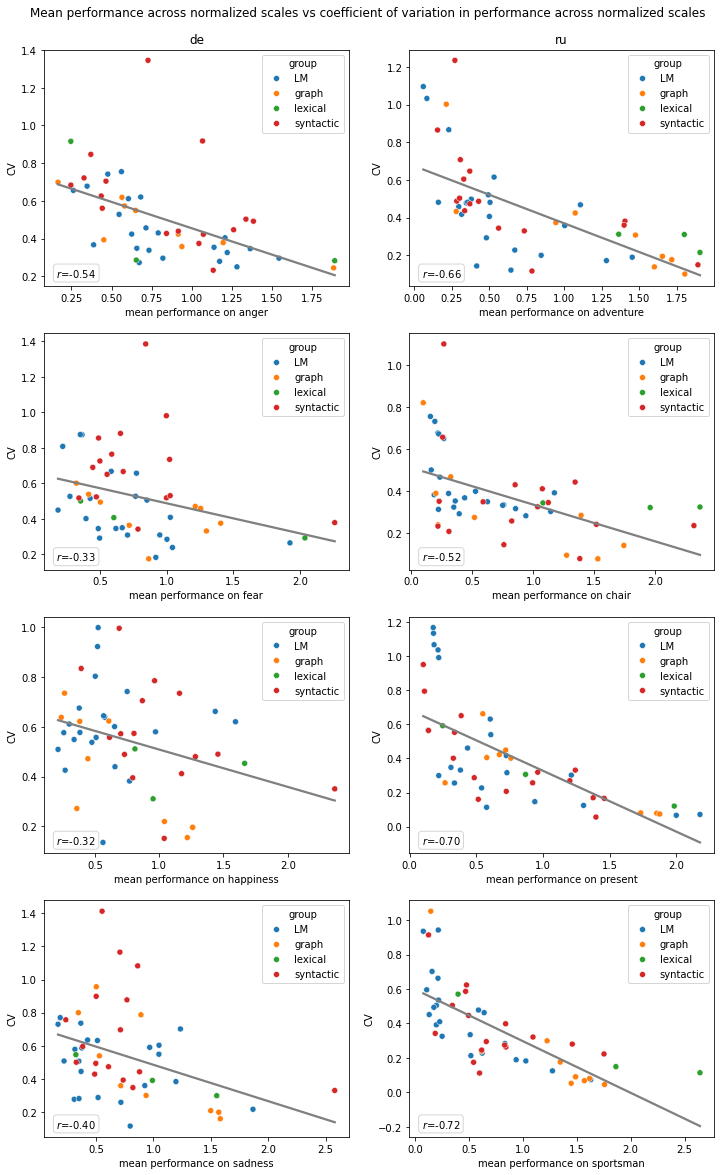

In [95]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
for i in range(4):
    for j, lang in enumerate(["de", "ru"]):
        task = long_df[long_df["lang"] == lang]["task"].unique()[i]
        ax = axes[i, j]
        if i == 0:
            ax.set_title(lang)
        y_name, x_name = f"diff_{task}_{lang}", f"perf_{task}_{lang}"
        y, x = diff_df_[y_name], diff_df_[x_name]
        sns.scatterplot(y=y, x=x, hue=diff_df_["group"], ax=ax)
        sns.regplot(y=y, x=x, 
                    ci=None, scatter=False, color='grey', ax=ax)
        coef = get_coefficient(x_name, y_name, x, y)
        ax.text(0.04, 0.08,
                f'$r$={coef:.2f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
        ax.set_ylabel('CV')
        ax.set_xlabel(f'mean performance on {task}')
fig.suptitle("Mean performance across normalized scales vs coefficient of variation in performance across normalized scales", y=0.91);
plt.savefig(f'{PATH_FIG}performance_vs_CV_across_normalized_scales.png', dpi=dpi, bbox_inches = 'tight')

best_perf_anger_de, diff_anger_de, 0.03, 0.85211
best_perf_adventure_ru, diff_adventure_ru, -0.52, 0.00009
best_perf_fear_de, diff_fear_de, 0.27, 0.05746
best_perf_chair_ru, diff_chair_ru, -0.34, 0.01476
best_perf_happiness_de, diff_happiness_de, 0.05, 0.71497
best_perf_present_ru, diff_present_ru, -0.56, 0.00002
best_perf_sadness_de, diff_sadness_de, 0.17, 0.24611
best_perf_sportsman_ru, diff_sportsman_ru, -0.62, 0.00000


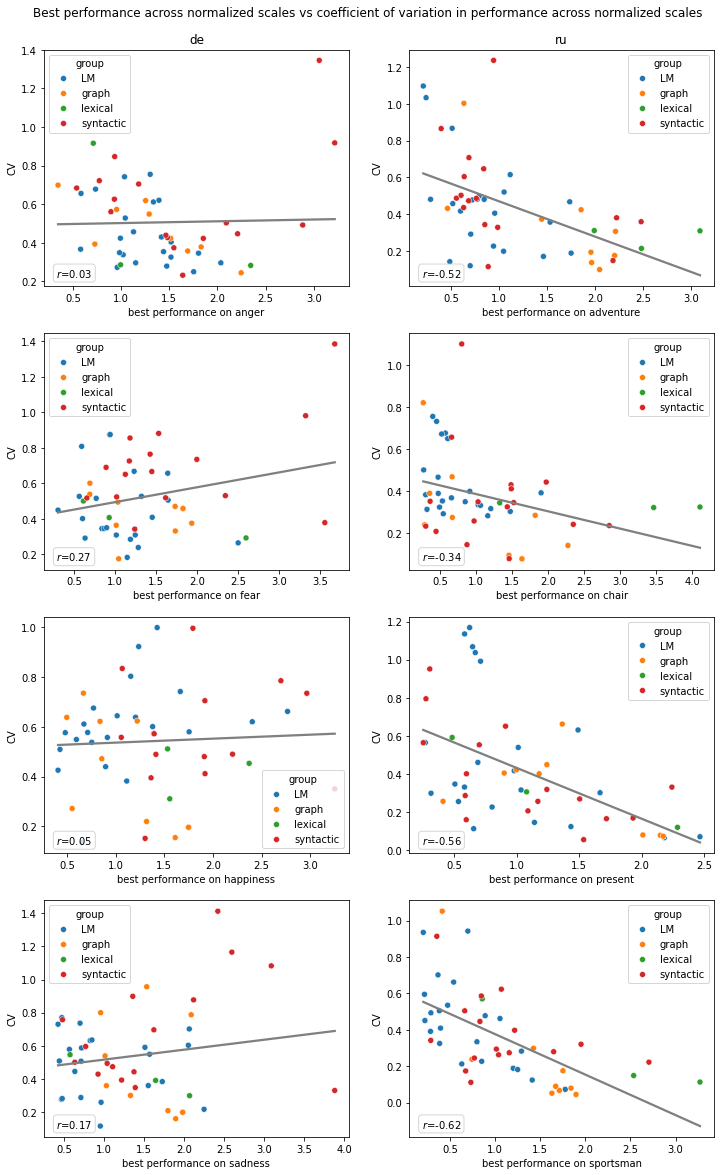

In [96]:
fig, axes = plt.subplots(4, 2, figsize=(12, 20))
for i in range(4):
    for j, lang in enumerate(["de", "ru"]):
        task = long_df[long_df["lang"] == lang]["task"].unique()[i]
        ax = axes[i, j]
        if i == 0:
            ax.set_title(lang)
        y_name, x_name = f"diff_{task}_{lang}", f"best_perf_{task}_{lang}"
        y, x=diff_df_[y_name], diff_df_[x_name]
        sns.scatterplot(y=y, x=x, hue=diff_df_["group"], ax=ax)
        sns.regplot(y=y, x=x, 
                    ci=None, scatter=False, color='grey', ax=ax)
        coef = get_coefficient(x_name, y_name, x, y)
        ax.text(0.04, 0.08,
                f'$r$={coef:.2f}', transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", edgecolor="0.8", alpha=0.8))
        ax.set_ylabel('CV')
        ax.set_xlabel(f'best performance on {task}')
fig.suptitle("Best performance across normalized scales vs coefficient of variation in performance across normalized scales", y=0.91);
plt.savefig(f'{PATH_FIG}best_performance_vs_CV_across_normalized_scales.png', dpi=dpi, bbox_inches = 'tight')

## Task differences (ICC2)

In [101]:
long_df[(long_df['lang'] == lang) & (long_df['scale'] == scale)]

,lang,task,scale,performance_metric,metric_group,metric_name,median,mean,CI_low,CI_high,...,corr_mean_sent_len_CI_high,corr_n_sents_median,corr_n_sents_mean,corr_n_sents_CI_low,corr_n_sents_CI_high,corr_n_words_median,corr_n_words_mean,corr_n_words_CI_low,corr_n_words_CI_high,normalized_median
153,de,anger,panss_total,r,LM,bert_cgcoh,0.036934,0.028916,-0.061874,0.115742,...,0.234068,-0.427345,-0.423362,-0.479451,-0.371816,-0.256949,-0.253674,-0.325628,-0.190699,0.970881
154,de,anger,panss_total,r,LM,bert_gcoh,-0.098277,-0.094821,-0.181987,-0.011278,...,0.387511,0.173175,0.172937,0.108922,0.236307,0.302896,0.300053,0.243522,0.365204,0.315866
155,de,anger,panss_total,r,LM,bert_lcoh,-0.133820,-0.124722,-0.223155,-0.032783,...,0.291620,0.291808,0.287562,0.235667,0.343694,0.358672,0.355693,0.308145,0.408769,0.143679
156,de,anger,panss_total,r,LM,bert_pppl,0.224542,0.232214,0.134259,0.324039,...,-0.142062,-0.480007,-0.477665,-0.509184,-0.447704,-0.488993,-0.486653,-0.517879,-0.455275,1.879727
157,de,anger,panss_total,r,LM,bert_scoh,-0.115479,-0.120691,-0.204692,-0.037212,...,0.233085,0.331298,0.329000,0.280878,0.378621,0.350305,0.347552,0.302592,0.399198,0.232534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,de,sadness,panss_total,r,graph,PE,-0.269662,-0.263418,-0.379967,-0.164537,...,0.301020,0.482556,0.483487,0.430986,0.540829,0.413537,0.414719,0.368688,0.460928,-0.911382
1424,de,sadness,panss_total,r,graph,degree_average,-0.229631,-0.224562,-0.349861,-0.106526,...,0.390299,0.434464,0.432834,0.386642,0.482012,0.411861,0.410253,0.367080,0.455254,-0.722382
1425,de,sadness,panss_total,r,graph,degree_std,-0.317423,-0.308588,-0.417339,-0.210246,...,0.450923,0.463002,0.460349,0.414120,0.509225,0.466058,0.464205,0.423372,0.503094,-1.136873
1426,de,sadness,panss_total,r,graph,number_of_edges,-0.457358,-0.445994,-0.526894,-0.379667,...,0.510313,0.530675,0.529984,0.499753,0.560742,0.560653,0.561677,0.528005,0.592891,-1.797556


In [102]:
pg.intraclass_corr(data=long_df[(long_df['lang'] == 'de') & (long_df['scale'] == 'panss_total')], targets='metric_name', raters='task', ratings='median', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.562028,6.132995,49,150,3.935041e-18,"[0.43, 0.69]"
1,ICC2,Single random raters,0.565740,6.652359,49,147,1.834404e-19,"[0.43, 0.7]"
2,ICC3,Single fixed raters,0.585594,6.652359,49,147,1.834404e-19,"[0.45, 0.71]"
3,ICC1k,Average raters absolute,0.836948,6.132995,49,150,3.935041e-18,"[0.75, 0.9]"
4,ICC2k,Average random raters,0.838997,6.652359,49,147,1.834404e-19,"[0.75, 0.9]"
5,ICC3k,Average fixed raters,0.849677,6.652359,49,147,1.834404e-19,"[0.77, 0.91]"


In [104]:
pg.intraclass_corr(data=long_df[(long_df['lang'] == 'de') & (long_df['scale'] == 'group_diff')], targets='metric_name', raters='task', ratings='median', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.836655,21.488013,49,150,2.119381e-47,"[0.76, 0.89]"
1,ICC2,Single random raters,0.837067,22.908422,49,147,1.743434e-48,"[0.76, 0.9]"
2,ICC3,Single fixed raters,0.845610,22.908422,49,147,1.743434e-48,"[0.78, 0.9]"
3,ICC1k,Average raters absolute,0.953462,21.488013,49,150,2.119381e-47,"[0.93, 0.97]"
4,ICC2k,Average random raters,0.953596,22.908422,49,147,1.743434e-48,"[0.93, 0.97]"
5,ICC3k,Average fixed raters,0.956348,22.908422,49,147,1.743434e-48,"[0.93, 0.97]"


In [127]:
pg.intraclass_corr(data=long_df[(long_df['lang'] == 'ru') & (long_df['scale'] == 'panss_total')], targets='metric_name', raters='task', ratings='median', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.667988,9.04776,50,153,1.885606e-26,"[0.55, 0.77]"
1,ICC2,Single random raters,0.669735,9.66370,50,150,1.262580e-27,"[0.55, 0.78]"
2,ICC3,Single fixed raters,0.684137,9.66370,50,150,1.262580e-27,"[0.57, 0.79]"
3,ICC1k,Average raters absolute,0.889475,9.04776,50,153,1.885606e-26,"[0.83, 0.93]"
4,ICC2k,Average random raters,0.890249,9.66370,50,150,1.262580e-27,"[0.83, 0.93]"
5,ICC3k,Average fixed raters,0.896520,9.66370,50,150,1.262580e-27,"[0.84, 0.94]"


In [105]:
pg.intraclass_corr(data=long_df[(long_df['lang'] == 'ru') & (long_df['scale'] == 'group_diff')], targets='metric_name', raters='task', ratings='median', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.633223,7.905802,50,153,1.586025e-23,"[0.51, 0.75]"
1,ICC2,Single random raters,0.632998,7.853439,50,150,3.823346e-23,"[0.51, 0.75]"
2,ICC3,Single fixed raters,0.631453,7.853439,50,150,3.823346e-23,"[0.51, 0.75]"
3,ICC1k,Average raters absolute,0.873511,7.905802,50,153,1.586025e-23,"[0.81, 0.92]"
4,ICC2k,Average random raters,0.873404,7.853439,50,150,3.823346e-23,"[0.81, 0.92]"
5,ICC3k,Average fixed raters,0.872667,7.853439,50,150,3.823346e-23,"[0.8, 0.92]"


#### rank

In [121]:
ranks = []
metric_names = []
tasks = []
langs = []
scales = []
for lang in ['ru', 'de']:
    for task in long_df[long_df['lang'] == lang]['task'].unique():
        for scale in ['panss_total', 'group_diff']:
            ranks.extend(long_df[(long_df['lang'] == lang) & (long_df['scale'] == scale) & (long_df['task'] == task)]['median'].rank().to_list())
            cur_mn = long_df[(long_df['lang'] == lang) & (long_df['scale'] == scale) & (long_df['task'] == task)]['metric_name'].to_list()
            metric_names.extend(cur_mn)
            langs.extend([lang] * len(cur_mn))
            tasks.extend([task] * len(cur_mn))
            scales.extend([scale] * len(cur_mn))

In [122]:
rank_df = pd.DataFrame({'lang':langs, 'scale': scales, 'task': tasks, 'metric_name': metric_names, 'rank': ranks})

In [123]:
pg.intraclass_corr(data=rank_df[(rank_df['lang'] == 'de') & (rank_df['scale'] == 'panss_total')], targets='metric_name', raters='task', ratings='rank', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.541868,5.731106,49,150,6.617219e-17,"[0.4, 0.68]"
1,ICC2,Single random raters,0.540807,5.617834,49,147,2.125314e-16,"[0.4, 0.68]"
2,ICC3,Single fixed raters,0.535846,5.617834,49,147,2.125314e-16,"[0.4, 0.67]"
3,ICC1k,Average raters absolute,0.825514,5.731106,49,150,6.617219e-17,"[0.73, 0.89]"
4,ICC2k,Average random raters,0.824898,5.617834,49,147,2.125314e-16,"[0.73, 0.89]"
5,ICC3k,Average fixed raters,0.821995,5.617834,49,147,2.125314e-16,"[0.73, 0.89]"


In [124]:
pg.intraclass_corr(data=rank_df[(rank_df['lang'] == 'de') & (rank_df['scale'] == 'group_diff')], targets='metric_name', raters='task', ratings='rank', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.677851,9.416603,49,150,7.609707e-27,"[0.56, 0.78]"
1,ICC2,Single random raters,0.677366,9.244202,49,147,3.821946e-26,"[0.56, 0.78]"
2,ICC3,Single fixed raters,0.673315,9.244202,49,147,3.821946e-26,"[0.55, 0.78]"
3,ICC1k,Average raters absolute,0.893805,9.416603,49,150,7.609707e-27,"[0.84, 0.93]"
4,ICC2k,Average random raters,0.893594,9.244202,49,147,3.821946e-26,"[0.84, 0.93]"
5,ICC3k,Average fixed raters,0.891824,9.244202,49,147,3.821946e-26,"[0.83, 0.93]"


In [125]:
pg.intraclass_corr(data=rank_df[(rank_df['lang'] == 'ru') & (rank_df['scale'] == 'panss_total')], targets='metric_name', raters='task', ratings='rank', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.690568,9.926929,50,153,1.507015e-28,"[0.58, 0.79]"
1,ICC2,Single random raters,0.690089,9.732283,50,150,8.758281e-28,"[0.58, 0.79]"
2,ICC3,Single fixed raters,0.685838,9.732283,50,150,8.758281e-28,"[0.57, 0.79]"
3,ICC1k,Average raters absolute,0.899264,9.926929,50,153,1.507015e-28,"[0.85, 0.94]"
4,ICC2k,Average random raters,0.899061,9.732283,50,150,8.758281e-28,"[0.84, 0.94]"
5,ICC3k,Average fixed raters,0.897249,9.732283,50,150,8.758281e-28,"[0.84, 0.94]"


In [126]:
pg.intraclass_corr(data=rank_df[(rank_df['lang'] == 'ru') & (rank_df['scale'] == 'group_diff')], targets='metric_name', raters='task', ratings='rank', nan_policy='omit')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.602332,7.058650,50,153,3.429269e-21,"[0.47, 0.72]"
1,ICC2,Single random raters,0.601540,6.920245,50,150,1.371948e-20,"[0.47, 0.72]"
2,ICC3,Single fixed raters,0.596784,6.920245,50,150,1.371948e-20,"[0.47, 0.72]"
3,ICC1k,Average raters absolute,0.858330,7.058650,50,153,3.429269e-21,"[0.78, 0.91]"
4,ICC2k,Average random raters,0.857927,6.920245,50,150,1.371948e-20,"[0.78, 0.91]"
5,ICC3k,Average fixed raters,0.855496,6.920245,50,150,1.371948e-20,"[0.78, 0.91]"


## Particle use

In [ ]:
from collections import Counter

In [ ]:
all_part_ru = set()
all_part_de = set()
data = {'lang': [], 'task': [], 'id': [], 'line_counts': []}
with open('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/part.tsv') as f:
    for line in f.readlines():
        line_counts = Counter()
        line = line.strip()
        els = line.split('\t')
        id_ = els[0]
        task_ = els[1]
        lang_ = 'de' if ("NET" in id_ or 'manual' in id_) else 'ru'
        set_ = all_part_de if lang_ == 'de' else all_part_ru
        for i in range(2, len(els[2:]), 2):
            if i + 1 < len(els[1:]):
                key, value = els[i], els[i+1]
                if key not in set_:
                    set_.add(key.lower())
                line_counts[key.lower()] += int(value)
        data['lang'].append(lang_)
        data['task'].append(task_)
        data['id'].append(id_)
        data['line_counts'].append(line_counts)

In [ ]:
data_df = data.copy()
del data_df['line_counts']
iddf = pd.DataFrame.from_dict(data_df)

In [ ]:
part_data = {}
for el in sorted(all_part_de | all_part_ru):
    part_data[el] = []
    for line in data['line_counts']:
        part_data[el].append(line[el])

In [ ]:
part_df = pd.concat([iddf, pd.DataFrame.from_dict(part_data).astype(float)], axis=1)

In [ ]:
ru = part_df[part_df['lang'] == 'ru'].sum(axis=0, numeric_only=True)
ru = ru[ru > 0]
print(ru.sort_values(ascending=False))

In [ ]:
de = part_df[part_df['lang'] == 'de'].sum(axis=0, numeric_only=True)
de = de[de > 0]
print(de.sort_values(ascending=False))

### result tables

In [174]:
ex = long_df[(long_df['lang'] == 'ru') & (long_df['task'] == 'adventure')][['metric_group', 'metric_name', 'scale', 'median', 'CI_low', 'CI_high']]

In [176]:
metric_to_group = {}
for mn in ex['metric_name'].unique():
    metric_to_group[mn] =  ex[ex['metric_name'] == mn]['metric_group'].iloc[0]

In [187]:
pivot = ex.pivot(index='metric_name', columns='scale', values=['median','CI_low','CI_high']).swaplevel(axis=1).sort_index(axis=1, level=0, ascending=False)
pivot['metric_group'] = pivot.index.map(lambda x: metric_to_group.get(x))
pivot = pivot.set_index('metric_group', append=True).reorder_levels(['metric_group', 'metric_name'])
pivot = pivot.sort_index(axis=0, level=1, ascending=False).sort_index(axis=0, level=0, ascending=False)

scale                        ps_r_td.severity                      \
                                       median    CI_low   CI_high   
metric_group metric_name                                            
syntactic    std_sent_len           -0.031514 -0.121687  0.062065   
             n_sents                -0.324810 -0.372254 -0.275347   
             min_sent_len            0.053041 -0.028829  0.142926   
             mean_sent_len          -0.176552 -0.280386 -0.079396   
             max_sent_len           -0.147891 -0.233988 -0.058108   
             VERB                    0.053413 -0.011766  0.124178   
             SCONJ                  -0.105687 -0.217401 -0.008472   
             PROPN                  -0.166893 -0.227008 -0.112864   
             PRON                   -0.099083 -0.190186 -0.011134   
             PART                    0.200475  0.104048  0.293151   
             NOUN                   -0.000511 -0.084420  0.086063   
             DET                    -0.193720 -0.264148 -0.114776   
             CCONJ                  -0.035564 -0.116604  0.050186   
             AUX                    -0.138346 -0.219935 -0.055032   
             ADV                     0.269968  0.203240  0.338811   
             ADJ                    -0.057381 -0.158362  0.049097   
lexical      n_words                -0.395038 -0.436936 -0.344948   
             MALTR                  -0.347210 -0.424567 -0.276832   
             LTR                     0.276319  0.193749  0.363906   
graph        number_of_nodes        -0.405932 -0.481438 -0.337261   
             number_of_edges        -0.400888 -0.476830 -0.325115   
             degree_std             -0.144074 -0.244735 -0.049959   
             degree_average         -0.113049 -0.207612 -0.028457   
             PE                     -0.315117 -0.381124 -0.247908   
             LSC                    -0.427970 -0.501711 -0.353111   
             LCC                    -0.405932 -0.481438 -0.337261   
             L3                      0.066449 -0.011113  0.135895   
             L2                      0.199298  0.111271  0.295381   
             L1                      0.233850  0.139904  0.323696   
LM           w2v_tf_scoh            -0.343203 -0.411544 -0.267198   
             w2v_tf_lcoh            -0.194592 -0.263059 -0.119469   
             w2v_tf_gcoh            -0.168287 -0.235432 -0.091916   
             w2v_tf_cgcoh           -0.027826 -0.108684  0.061567   
             w2v_avg_scoh           -0.309229 -0.382950 -0.239721   
             w2v_avg_lcoh           -0.195945 -0.271809 -0.112133   
             w2v_avg_gcoh           -0.146567 -0.219950 -0.069267   
             w2v_avg_cgcoh          -0.016793 -0.101281  0.069620   
             glove_tf_scoh          -0.149436 -0.250283 -0.053843   
             glove_tf_lcoh          -0.137026 -0.232243 -0.038932   
             glove_tf_gcoh          -0.125818 -0.222550 -0.024422   
             glove_tf_cgcoh         -0.100041 -0.198389  0.005995   
             glove_avg_scoh         -0.100685 -0.192065 -0.006638   
             glove_avg_lcoh         -0.101861 -0.196197 -0.007375   
             glove_avg_gcoh         -0.021137 -0.119703  0.075523   
             glove_avg_cgcoh         0.067967 -0.022804  0.156991   
             bert_sprob             -0.139384 -0.224342 -0.042261   
             bert_scoh               0.028080 -0.069864  0.124862   
             bert_pppl              -0.119977 -0.225736 -0.019769   
             bert_lcoh               0.028158 -0.076976  0.133796   
             bert_gcoh               0.154737  0.041805  0.243087   
             bert_cgcoh              0.189782  0.079241  0.268529   

scale                        ps_r_dep.severity                      \
                                        median    CI_low   CI_high   
metric_group metric_name                                             
syntactic    std_sent_len            -0.031514 -0.121687  0.062

In [190]:
with pd.ExcelWriter('result_values.xlsx') as writer:
    for lang in ['ru', 'de']:
        for task in long_df[long_df['lang'] == lang]['task'].unique():
            ex = long_df[(long_df['lang'] == lang) & (long_df['task'] == task)][['metric_group', 'metric_name', 'scale', 'median', 'CI_low', 'CI_high']]
            pivot = ex.pivot(index='metric_name', columns='scale', values=['median','CI_low','CI_high']).swaplevel(axis=1).sort_index(axis=1, level=0, ascending=False)
            pivot['metric_group'] = pivot.index.map(lambda x: metric_to_group.get(x))
            pivot = pivot.set_index('metric_group', append=True).reorder_levels(['metric_group', 'metric_name'])
            pivot = pivot.sort_index(axis=0, level=1, ascending=False).sort_index(axis=0, level=0, ascending=False)        
            pivot.to_excel(writer, sheet_name=f'{lang} {task}')  